# Import Libraries

In [262]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
from torchsummary import summary
torch.manual_seed(0)

import time

from Models import VAEConvolutionalAutoencoder

from sklearn.decomposition import PCA
from umap import UMAP

In [263]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

WHAT DOES AN AUTO£ENCIOD£E DO AND WHAT AM I TRYING TO LOOKM AT

# Import MNIST dataset

We are using the MNIST handwritten digits dataset for this analysis into an Autoencoder's Latent Space. I will be further applying the same concepts to a more practicle dataset, but to understand the machanics behind image augmentation the MNIST dataset allows us to easily visualise the change in images across the latent space.

The only transformation we are applying is zero padding to ensure even dimensions when using convolutional layers.

In [265]:
image_channels = 1
image_size = 32

In [266]:
transform = transforms.Compose([
                        transforms.ToTensor()
                        ,transforms.Pad(padding=2, fill=0)
                ])

In [267]:
train_dataset = torchvision.datasets.MNIST("./", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST("./", train=False, transform=transform, download=True)

In [268]:
indices = list(range(0, 5000))
#train_dataset = torch.utils.data.Subset(train_dataset, indices)
#test_dataset = torch.utils.data.Subset(test_dataset, indices)

In [269]:
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=500, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2000, shuffle=True)

## Helper Functions

- Function to display torch tensor as image

In [270]:
def display_image(image, size=150):

    image = image.detach().reshape(image_size, image_size).numpy()
   
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    #plt.show()

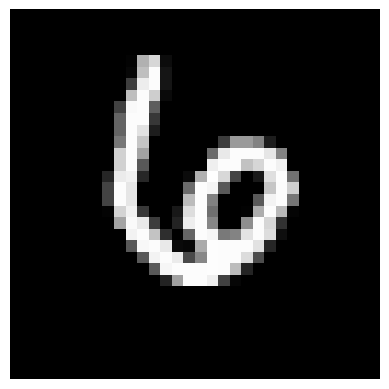

In [271]:
display_image(next(iter(train_data_loader))[0][0])

- Function to display Train and Test losses

In [285]:
def display_loss(train_loss, test_loss):

    plt.figure(figsize=(5,5))
    
    plt.plot(np.arange(1,len(train_loss)+1,1), train_loss, label='Train Loss')
    plt.plot(np.arange(1,len(test_loss)+1,1), test_loss, label='Test Loss')

    plt.legend()

def display_latent_space(model):
    
    images, labels = next(iter(test_data_loader))
    
    images = images.to(device=device)
    labels = labels
    
    model.eval()
    
    with torch.no_grad():
    
        latent_representation = model.encoder(images).cpu()
    
    sns.scatterplot(x=latent_representation[:,0], y=latent_representation[:,1], hue=labels.numpy(), palette=sns.color_palette("tab10", 10))

    plt.show()


- Function to display n original vs decoded images from a trained model 

In [307]:
def display_decoded_images(model, n_images=5):

    train_images = next(iter(test_data_loader))[0][0:n_images].detach()
    
   
    
    for n, test_image in enumerate(train_images):
        
        plt.figure(figsize=(5, 20))
        
        plt.subplot(n_images,2,2*n+1)
        display_image(test_image)
        model.eval()
        with torch.no_grad():      
            test_image = test_image.to(device=device)
            
            sig = nn.Sigmoid()
            decoded_image = sig(model(test_image.reshape(1,1,image_size,image_size)).cpu().reshape(1,image_size,image_size))
            
        plt.subplot(n_images,2,2*n+2)
        
        display_image(decoded_image)  
    
    plt.show()

In [274]:
train_images = next(iter(train_data_loader))[0][0:500]
test_images = next(iter(test_data_loader))[0][0:500]

# Define Learning Function & Custom Loss Function

Here we define our custom loss function that combines the BCE reconstruction loss with the KL divergence.

The Reconstruction loss is standard for an autoencoder and measures how close the decoded image is from the original image, usually using MSE or BSE loss.

The KL Divergence loss is used on the latent space of an Autoencoder to enforce the latent space to have continuity and completeness.
- Continuity - points in the latent space close to each other should be similar, i.e. in our use case the same number, or numbers with similar shapes, should be close to each other in the latent space.
- Completeness - all points in the latent space should represent a sample from the dataset, so sampled points in the latent space should all decode to a meaningful image. In our case this means when sampling from across the latent space, all images should be recognisable as digits but with slightly different properties.

A Variational Autoencoder (VAE) is unqiue in that, rather than outputting single values for the n dimensions in it's latent space, it outputs a mean and standard deviation for each dimension. A single point is then randomly sampled from, in our case, a gaussian distribution with the given mean and std. This helps to create a more continuous latent space since an input can be encoded into a range of similar output values. It also creates a more compelete latent space by spreading out the latent space representations for each image.

The way that the KL Divergence is enforced on the VAE's latent space is to constrain the gassian sampled points in the latent space across a batch to have a mean of 0 and a standard deviation of 1.

The  calculation for the KL Loss is taken from the below paper, and works when the prior and posterior approximations are assumed to be Gaussian.

https://arxiv.org/pdf/1312.6114v10

Another form of the KL Divergance for the Gaussian case exists where the model outputs log(variance) rather than the standard deviation, and this help with stability during training, but for out simpler dataset, and for better understanding of the maths, I have used the standard deviation version.

In [297]:
bce_loss = nn.BCEWithLogitsLoss(reduction='mean')

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x_pred, x, latent_space, kl_lambda=1):

        self.reconstruction_loss = bce_loss(x_pred, x)
    
        mean_latent = latent_space.mean(axis=0)
        std_latent = latent_space.std(axis=0)
    
        self.kl_loss = - 0.5 * torch.sum(1 + torch.log(std_latent**2) - mean_latent**2 - std_latent**2)
        
        return self.reconstruction_loss + self.kl_loss * kl_lambda

We define a learning function that keep track of the total loss (which is used in backpropagation), and the KL divergence loss and reconstructionn loss separately. From this we can better underdtand the performance of the model, and and tweak the KL loss lambda if required (a value of 1 performs well).

In [276]:
def train_model(n_epochs, model, output_frequency=10):
    
    start = time.time()
    
    for epoch in range(n_epochs):
        
        batch_train_losses = []
        batch_test_losses = []
        
        batch_kl_train_losses = []
        batch_kl_test_losses = []
        
        batch_reconstruction_train_losses = []
        batch_reconstruction_test_losses = []

        train_count = 0
        test_count = 0
    
        model.train()

        for x, _ in train_data_loader:
    
            x = x.to(device=device)
          
            x_pred = model(x)
            
            optimizer.zero_grad()
            
            loss = criterion(x_pred, x, model.latent_space)
            
            loss.backward()
    
            optimizer.step()

            batch_train_losses.append(loss.item()*len(x))
            batch_kl_train_losses.append(criterion.kl_loss.item()*len(x))
            batch_reconstruction_train_losses.append(criterion.reconstruction_loss.item()*len(x))
            
            train_count += len(x.cpu())
            
        model.eval()
        
        with torch.no_grad():

            train_losses.append(np.sum(batch_train_losses)/train_count)
            kl_train_losses.append(np.sum(batch_kl_train_losses)/train_count)
            reconstruction_train_losses.append(np.sum(batch_reconstruction_train_losses)/train_count)
            
            for x, _ in test_data_loader:     

                x = x.to(device=device)
                
                x_pred = model(x)

                loss = criterion(x_pred, x, model.latent_space)
                
                batch_test_losses.append(loss.item()*len(x))
                batch_kl_test_losses.append(criterion.kl_loss.item()*len(x))
                batch_reconstruction_test_losses.append(criterion.reconstruction_loss.item()*len(x))
                
                test_count += len(x)
        
            test_losses.append(np.sum(batch_test_losses)/test_count)
            kl_test_losses.append(np.sum(batch_kl_test_losses)/test_count)
            reconstruction_test_losses.append(np.sum(batch_reconstruction_test_losses)/test_count)
            
        end = time.time()
    
        if (epoch+1) % (output_frequency) == 0:
            print(f'Ran epoch {epoch+1} in {int(end - start)} seconds with training loss {train_losses[-1]:.3f} and testing loss {test_losses[-1]:.3f}')

        start = time.time()    

    return model

# Create the Variational Autoencoder 

We have defined our Variational Autoencoder model below using Pytorch.

The encoder, the part of the model that encodes inputs into the latent space, is comprised of 3 convolutional layers and a linear layer. The exact properties of the layers can be defined as inputs in to the model class. The encoder outputs 2n points representing the mean and standard deviation used to gaussian sample points in the n dimensional latent space. The method for gaussian sampling uses the "Reparameterization Trick", as described in https://arxiv.org/pdf/1312.6114v10. This allows the backpropergation to flow through the network since we're sampling from a gaussian distribution with mean 0 and std 1, and then just multiplying by our std and adding our mean. These latter opperations are differentiable and so the model can learn. 

The decoder part of the model then takes the n dimensions of the latent space and attempts to reconstruct the original image. The architecture of the decoder is opposite to the encoder, a linear layer then transposed convolutional layers to increase the image dimensions back to the original size.

In [298]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, layers, image_dim, image_channels, layer_1_channels, layer_2_channels, layer_3_channels, latent_layer_output, device=torch.device('cpu')):

        super().__init__()
        
        self.encoder_conv_dim = int(self.kernal_output_size(layers, image_dim, kernal_size=3, padding=1, stride=2))  
        self.flatten_dim = int(self.encoder_conv_dim ** 2 * layer_3_channels)   
        self.latent_layer_output = latent_layer_output
        self.device = device
        
        # Encoder
        self.encoder_sequential = nn.Sequential(
            self.conv_layer_block(image_channels, layer_1_channels, kernel_size=3, padding=1, stride=2, encoder=True)
            ,self.conv_layer_block(layer_1_channels, layer_2_channels, kernel_size=3, padding=1, stride=2, encoder=True)
            ,self.conv_layer_block(layer_2_channels, layer_3_channels, kernel_size=3, padding=1, stride=2, encoder=True)

            ,nn.Flatten()
            ,nn.Sequential(
                    nn.Linear(self.flatten_dim, 2*latent_layer_output)
                    ,torch.nn.BatchNorm1d(2*latent_layer_output)
            )
        )

        # Decoder
        self.decoder_sequential = nn.Sequential(
            nn.Sequential(
                    nn.Linear(latent_layer_output, self.flatten_dim)
                     ,torch.nn.BatchNorm1d(self.flatten_dim)
            )
            ,nn.Unflatten(1, (layer_3_channels, self.encoder_conv_dim ,self.encoder_conv_dim))
            
            ,self.conv_layer_block(layer_3_channels, layer_2_channels, kernel_size=3, padding=1, stride=2, encoder=False)
            ,self.conv_layer_block(layer_2_channels, layer_1_channels, kernel_size=3, padding=1, stride=2, encoder=False)
            
            ,nn.Sequential(
                nn.ConvTranspose2d(layer_1_channels, image_channels, kernel_size=3, stride=2, padding=1, output_padding = 1),
            )
        )
        
    # used to construct the convolutional layers using a standard form of conv layer, batch norm and relu
    def conv_layer_block(self, in_channels, out_channels, kernel_size, padding=1, stride=2, encoder=True):
        if encoder:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                torch.nn.BatchNorm2d(out_channels),
                nn.ReLU(True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding = 1),
                torch.nn.BatchNorm2d(out_channels),
                nn.ReLU(True)
            )

    # recursive function used to calculate the output kernal size for a conv layer so that we can calculate the dimension of the linear layer
    def kernal_output_size(self, layers, input_size, kernal_size, padding, stride):
        output_size = np.floor((input_size - kernal_size + 2 * padding)/ stride)+1
        layers -= 1  
        if layers > 0:
            output_size = self.kernal_output_size(layers, output_size, kernal_size, padding, stride)
        return output_size

    def gaussian_sample(self, x):       
        gaus_sample = torch.tensor(np.random.normal(loc=0, scale=1, size=self.latent_layer_output)
                             ,dtype=torch.float).to(self.device)
        x = x.view(-1, 2, self.latent_layer_output)
        return x[:,0] * gaus_sample + x[:,1]

            
    def encoder(self, x):      
        x = self.encoder_sequential(x)
        x = self.gaussian_sample(x)
        return x

    def decoder(self, x):      
        x = self.decoder_sequential(x)
        return x
        
    def forward(self, x):
        x = self.encoder(x)
        self.latent_space = x
        x = self.decoder(x)
        return x

# Train Model


Model parameters are defined below. I have chosen a dimension of 5 for the latent space as this allows the model to encode enough information to accurately reconstuct the images. I originally experimented with 2 dimensions for ease of visualisation, but the performance of 5 was much better. We later use dimensionality reduction methods (PCA, UMAP & T-SNE) to help us visualise the latent space.

In [289]:
layers = 3
layer_1_channels = 16
layer_2_channels = 32
layer_3_channels = 64
latent_layer_output = 5

In [290]:
VAE_conv_model = VariationalAutoencoder(layers
                                             ,image_size
                                             ,image_channels
                                             ,layer_1_channels
                                             ,layer_2_channels
                                             ,layer_3_channels
                                             ,latent_layer_output
                                             ,device
                                            ).to(device)

In [291]:
summary(VAE_conv_model, input_size=(1, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             160
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           4,640
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
      BatchNorm1d-12                   [-1, 10]              20
           Linear-13                 [-1, 1024]           6,144
      BatchNorm1d-14                 [-

In [292]:
learning_rate = 0.001

criterion  = CustomLoss()

optimizer = torch.optim.Adam(VAE_conv_model.parameters()
                        ,lr=learning_rate
                        )

In [293]:
train_losses = []
test_losses = []

kl_train_losses = []
kl_test_losses = []

reconstruction_train_losses = []
reconstruction_test_losses = []

VAE_conv_model = train_model(n_epochs=50, model=VAE_conv_model, output_frequency=5)

Ran epoch 5 in 10 seconds with training loss 0.524 and testing loss 0.510
Ran epoch 10 in 10 seconds with training loss 0.370 and testing loss 0.326
Ran epoch 15 in 9 seconds with training loss 0.229 and testing loss 0.200
Ran epoch 20 in 9 seconds with training loss 0.172 and testing loss 0.156
Ran epoch 25 in 9 seconds with training loss 0.152 and testing loss 0.150
Ran epoch 30 in 9 seconds with training loss 0.133 and testing loss 0.143
Ran epoch 35 in 9 seconds with training loss 0.124 and testing loss 0.128
Ran epoch 40 in 9 seconds with training loss 0.119 and testing loss 0.126
Ran epoch 45 in 9 seconds with training loss 0.116 and testing loss 0.123
Ran epoch 50 in 10 seconds with training loss 0.113 and testing loss 0.118


# View Model Results

The model is able to minimise both BCE loss and the KL Divergence, with improvements plateuing around epoch 50.

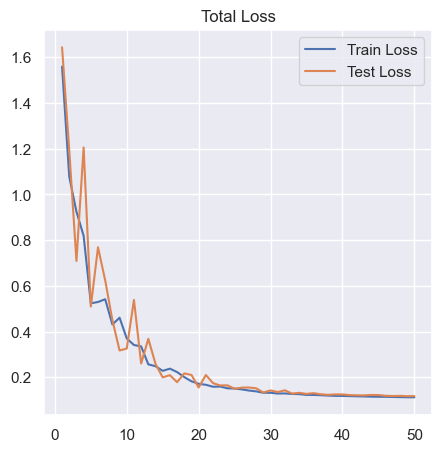

In [294]:
display_loss(train_losses, test_losses)
plt.title('Total Loss')
plt.show()

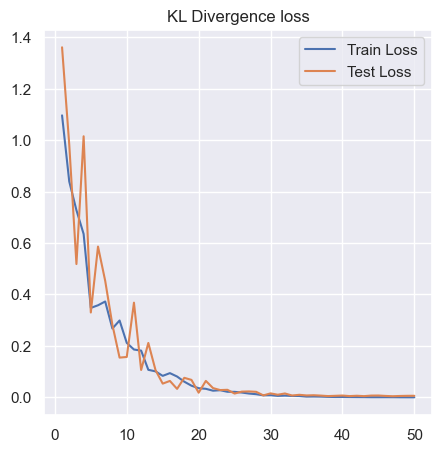

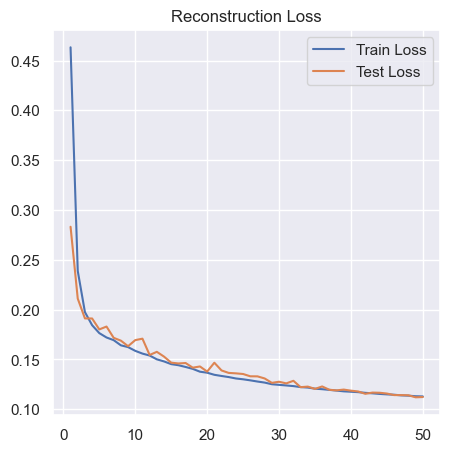

In [295]:
display_loss(kl_train_losses, kl_test_losses)
plt.title('KL Divergence loss')
plt.show()
display_loss(reconstruction_train_losses, reconstruction_test_losses)
plt.title('Reconstruction Loss')
plt.show()


Below you can see the original image (left) vs the model's re-constructed image (right).

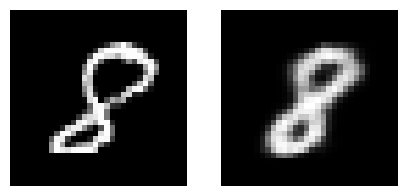

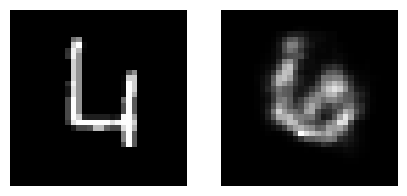

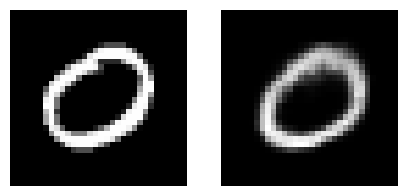

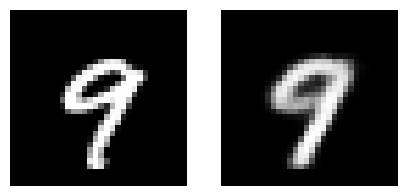

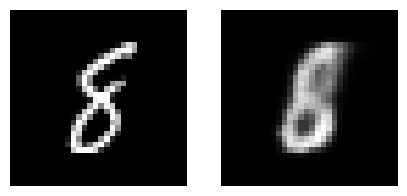

In [308]:
display_decoded_images(VAE_conv_model, n_images=5)

# Investigate Latent Space Sampling

Next we will investigate latent space sampling. This involves picking points in the model's latent space and running them through the models decoder to generate new images. Through this we can see how the latent space of the model is structed and how different regions of the latent space encode numbers with different properties.

Here, I have encoded a batch of test set images and used PCA to find the best 2 dimensional representation for each of the digits (0-9) seperatelly. From this we can view the 2D plane with the highest variance per digit, and sample across this to see how the properties of each digit are encoded, and how different digits with similar properties are encoded similarly.

In [245]:
images, labels = next(iter(test_data_loader))

images = images.to(device=device)
labels = labels

VAE_conv_model.eval()

with torch.no_grad():

    latent_representation = VAE_conv_model.encoder(images).cpu()

These functions fit the pca models and visualise the sampling results.

In [255]:
# fit 2 PCA components for a given label
def pca_components(latent_sample, labels, label):

    latent_sample_subset = latent_sample[labels==label].numpy()

    pca_model = PCA(n_components=2)

    latent_sample_pca = pca_model.fit_transform(latent_sample_subset)
    
    return pca_model, latent_sample_pca

# sample across the 2D space and inverse transform back to latent space representation
def pca_space_sampler(pca_model, latent_sample_pca, x_lims, y_lims, sample_dim):

    pca_sample_x = np.linspace(x_lims[0], x_lims[1], sample_dim+2)[1:-1]
    pca_sample_y = np.linspace(y_lims[0], y_lims[1], sample_dim+2)[1:-1]
    
    pca_space_coords = np.array(np.meshgrid(pca_sample_x, pca_sample_y)).T.reshape(-1,2)

    pca_space_inverse = pca_model.inverse_transform(pca_space_coords)

    return pca_space_coords, pca_space_inverse
    
# decode the latent space representations using our trained model
def decode_inverse_pca_sample(model, pca_space_inverse):

    latent_space_sample = torch.tensor(pca_space_inverse, dtype=torch.float32).to(device)

    sig = nn.Sigmoid()
    
    decoded_samples = sig(model.decoder(latent_space_sample)).cpu().detach().numpy()

    return decoded_samples

# plot the results of our PCA space and grid of sampled images
def plot_pca_sampled_images(ax, pca_space_coords, decoded_samples, sample_dim):

    pca_space_spacing_x = pca_space_coords[sample_dim+1,0]-pca_space_coords[0,0]
    pca_space_spacing_y = pca_space_coords[1,1]-pca_space_coords[0,1]

    ax.grid('on')

    for coord, decoded_sample in zip(pca_space_coords, decoded_samples):

        ax.imshow(decoded_sample.reshape(32,32)
                  ,extent=[coord[0]-0.5*pca_space_spacing_x,coord[0]+0.5*pca_space_spacing_x
                           ,coord[1]-0.5*pca_space_spacing_y,coord[1]+0.5*pca_space_spacing_y]
                 )

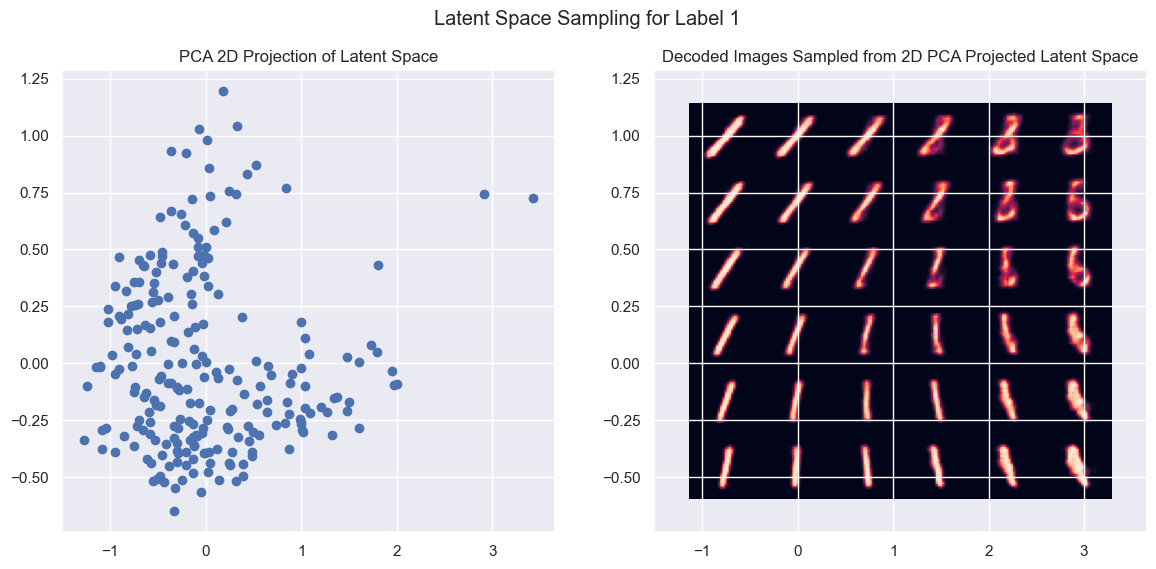

The two strongest Principle Components for label 1 account for 91.1% of the explained variance.


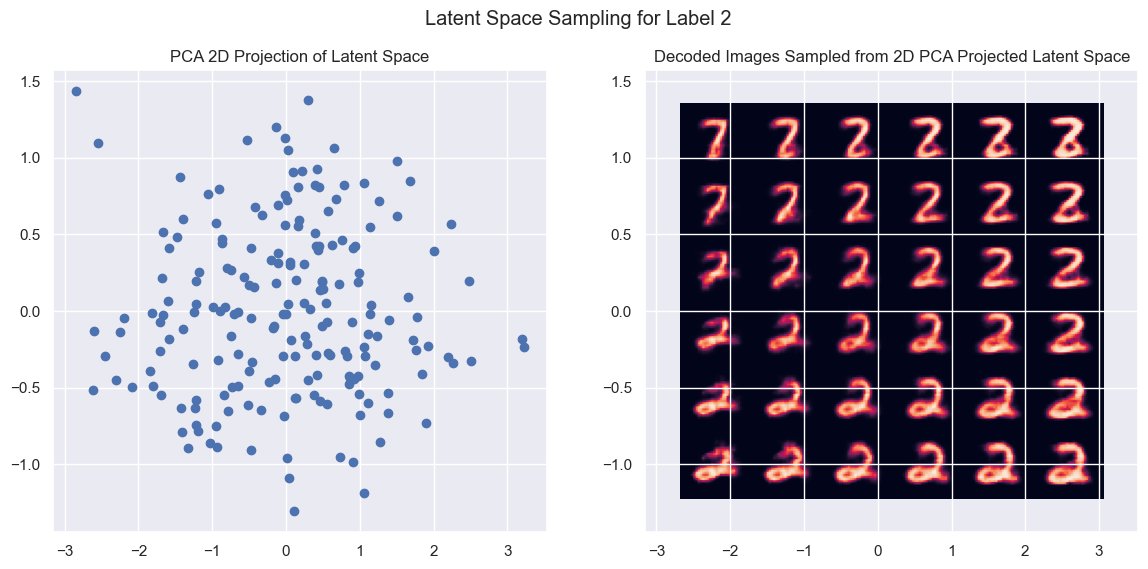

The two strongest Principle Components for label 2 account for 85.7% of the explained variance.


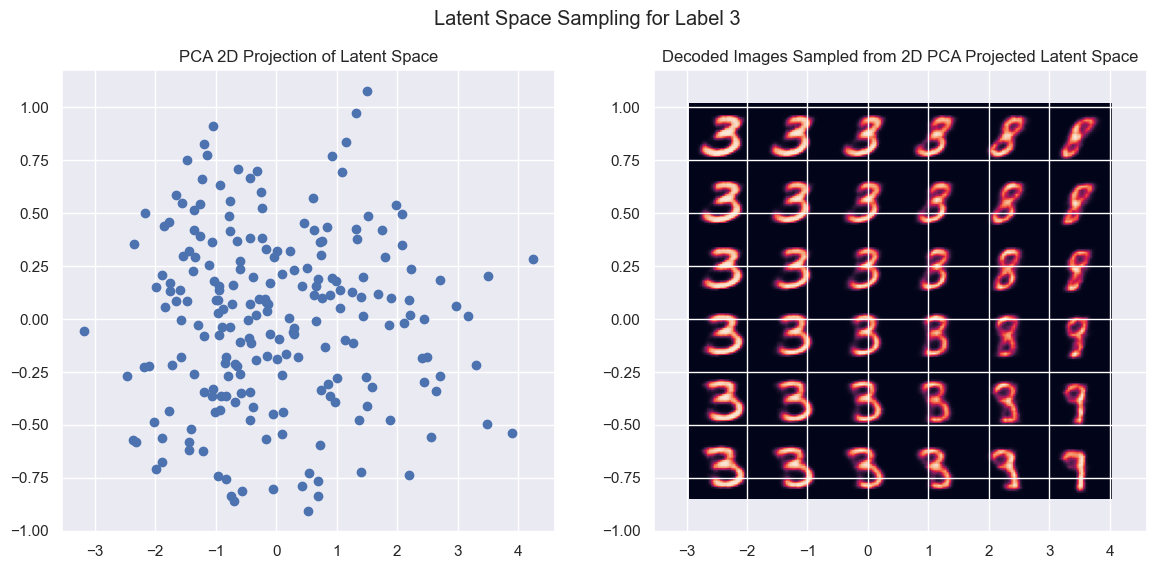

The two strongest Principle Components for label 3 account for 94.8% of the explained variance.


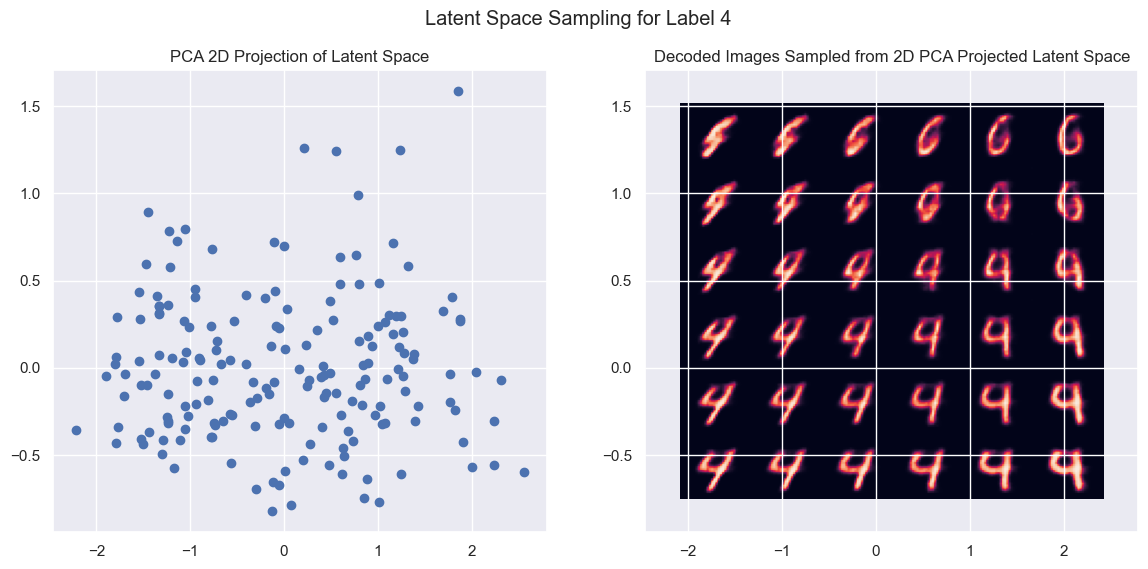

The two strongest Principle Components for label 4 account for 88.5% of the explained variance.


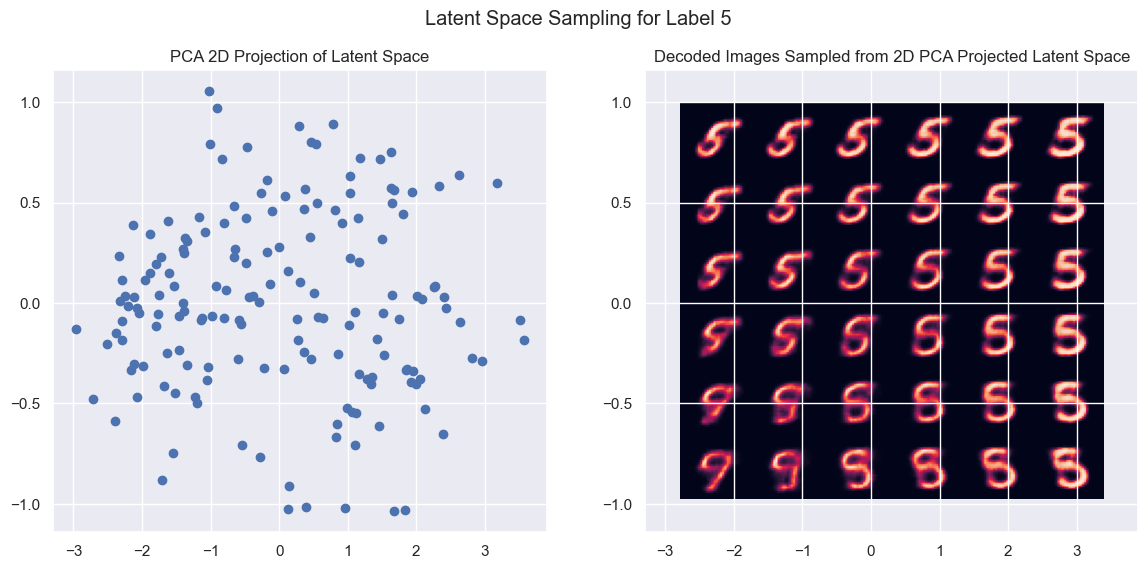

The two strongest Principle Components for label 5 account for 95.3% of the explained variance.


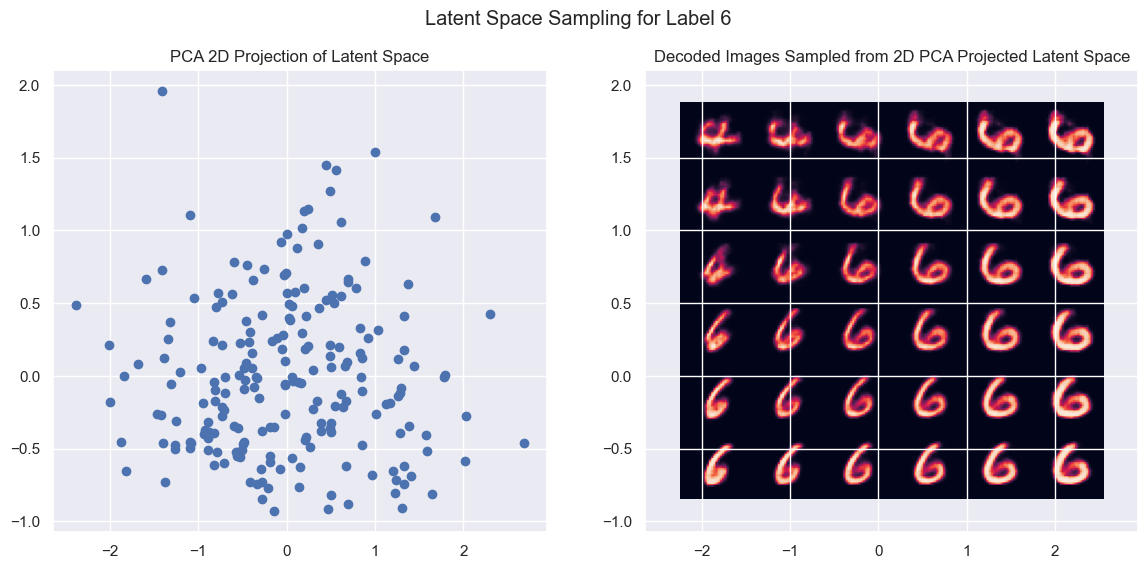

The two strongest Principle Components for label 6 account for 83.5% of the explained variance.


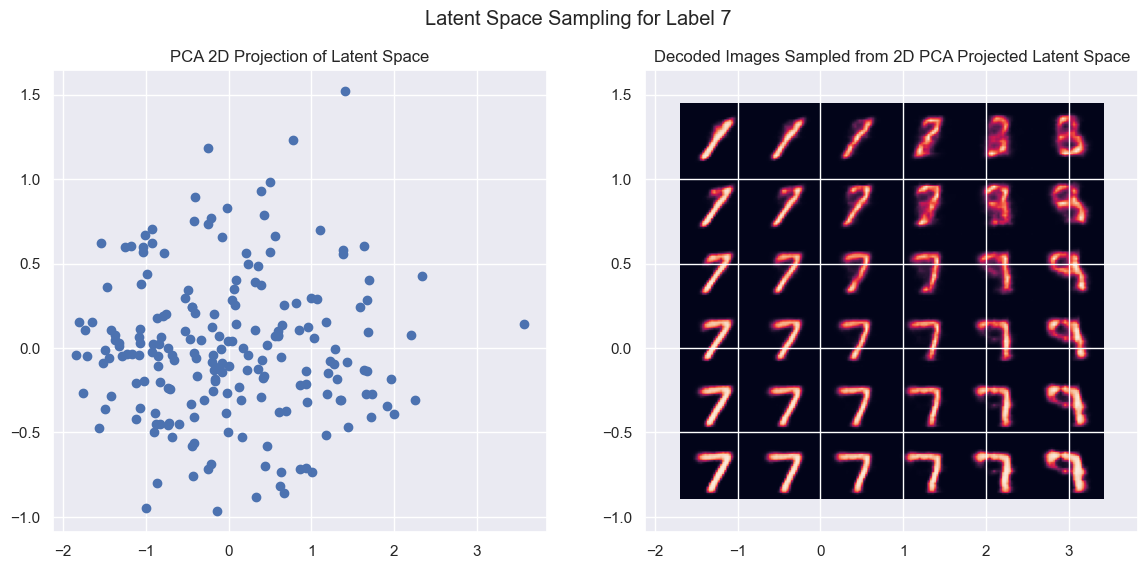

The two strongest Principle Components for label 7 account for 86.2% of the explained variance.


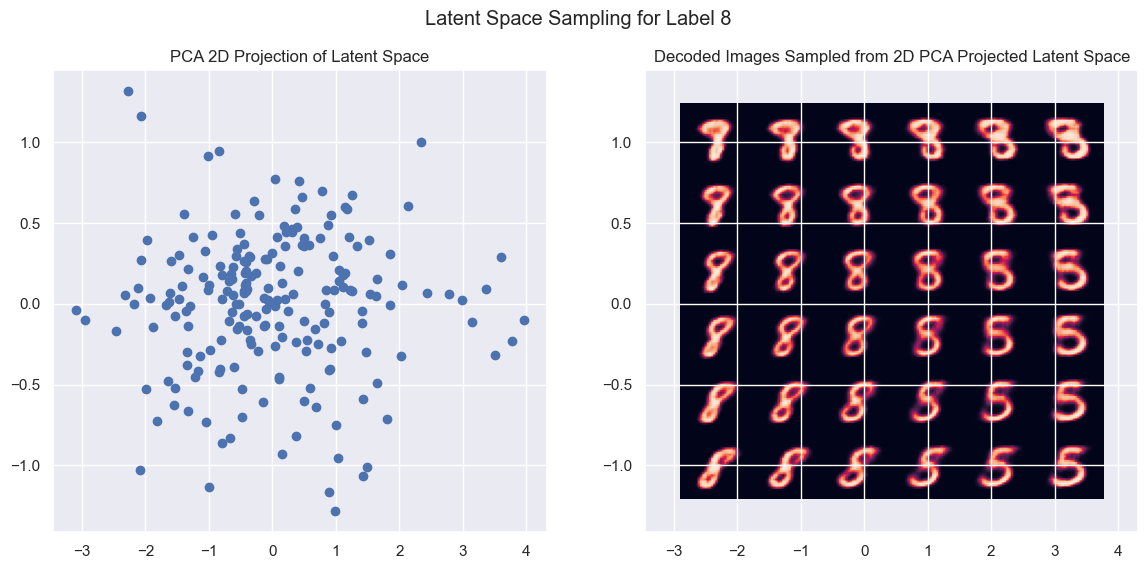

The two strongest Principle Components for label 8 account for 92.7% of the explained variance.


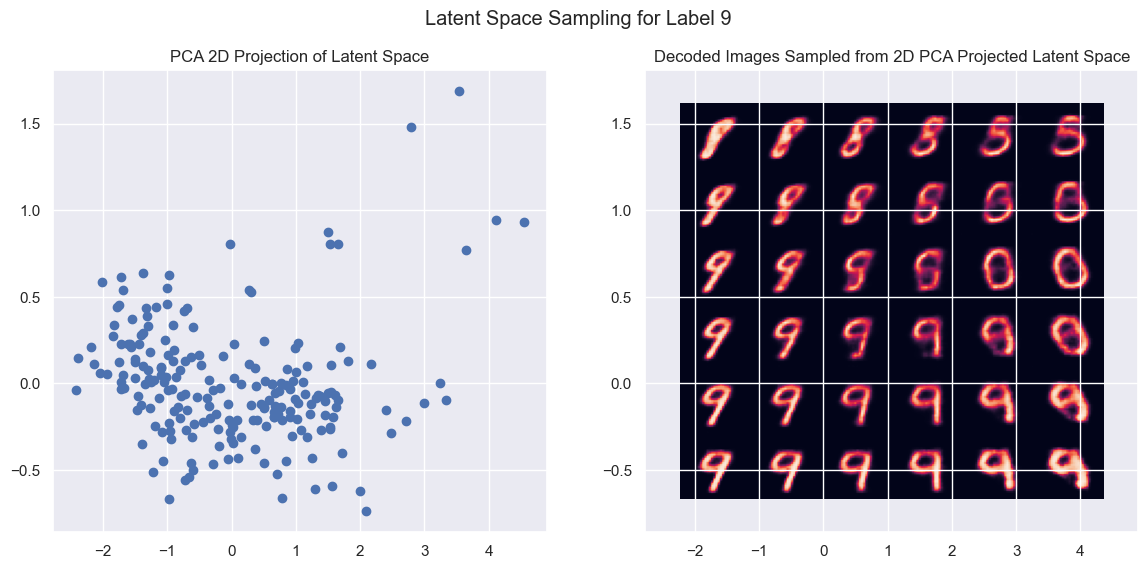

The two strongest Principle Components for label 9 account for 92.9% of the explained variance.


In [256]:
sample_dim=6

for label in np.arange(1,10,1):

    pca_model, latent_sample_pca = pca_components(latent_representation, labels, label)


    fig, axs = plt.subplots(1,2, figsize=(14, 6))
    fig.suptitle(f'Latent Space Sampling for Label {label}')
    axs[0].scatter(latent_sample_pca[:,0], latent_sample_pca[:,1])
    axs[0].set_title('PCA 2D Projection of Latent Space')
    x_lims = axs[0].get_xlim()
    y_lims = axs[0].get_ylim()

    

    pca_space_coords, pca_space_inverse = pca_space_sampler(pca_model, latent_sample_pca, x_lims, y_lims, sample_dim=sample_dim)

    decoded_samples = decode_inverse_pca_sample(VAE_conv_model, pca_space_inverse)
     
    plot_pca_sampled_images(axs[1] ,pca_space_coords, decoded_samples, sample_dim)

    axs[1].set_xlim(x_lims)
    axs[1].set_ylim(y_lims)
    axs[1].set_aspect('auto')
    axs[1].set_title('Decoded Images Sampled from 2D PCA Projected Latent Space')
    
    plt.show()

    print(f'The two strongest Principle Components for label {label} account for {pca_model.explained_variance_ratio_.sum():.1%} of the explained variance.')



# View 2D Latent Space Projections

In [257]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)

In [258]:
proj_2d = umap_2d.fit_transform(latent_representation)

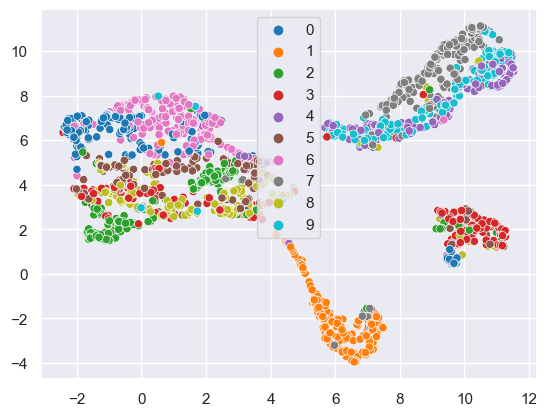

In [259]:
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1], hue=labels, palette=sns.color_palette('tab10'))

plt.show()

In [260]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(latent_representation)


<Axes: >

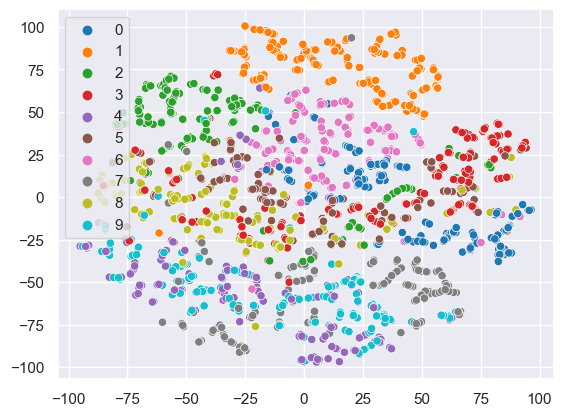

In [261]:
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=labels, palette=sns.color_palette('tab10'))